# Who's biking in California and why?
## by Ahmed Magdy

## Investigation Overview

> In this presentation, I'll be showing the trends and surprises found during investigation of the trip data provided by the Ford Gobike service.

## Dataset Overview

> The data investigated here is the trip data of the bike sharing service Ford GoBike. It provides details about trip times and duration, gender and age of the user, the pickup and final stations, and finally whether or not the user is participating in the "Bike Share For All" program, made specially for people with low income. The data has those details for more than 180,000 trips taken during the month of Febraury of 2019.

In [51]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [52]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [53]:
#The cleaning code
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)
df.loc[df.member_birth_year.isna(), 'member_birth_year'] = 3000 #to keep the rows with nulls
df = df[df.member_birth_year > 1920]
df.loc[df.member_birth_year == 3000, 'member_birth_year'] = np.NaN

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Summary Statistics

> Here's a summary about the demographics in out data. Women are suprisingly underserved in our data.

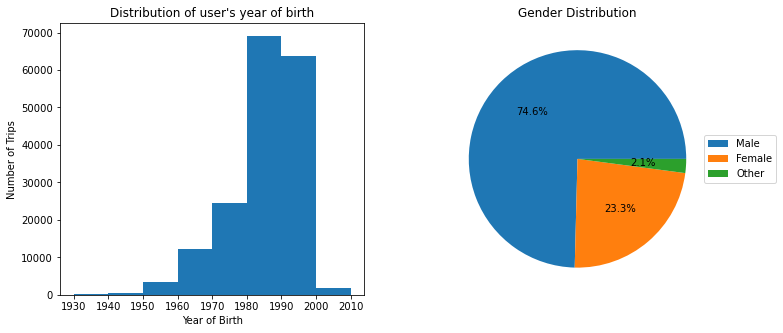

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# polish the age distribution graph
bins = range(1930, 2020, 10)
ax1.hist(data=df, x='member_birth_year', bins=bins)
ax1.set_title("Distribution of user's year of birth")
ax1.set_xlabel('Year of Birth')
ax1.set_ylabel('Number of Trips')

# draw the gender distribution, it's already polished
genders = df.member_gender.value_counts()
ax2.set_title('Gender Distribution')
ax2.pie(genders, autopct='%.1f%%')
ax2.legend(genders.index, bbox_to_anchor=(1, 0, 0.25, 1), loc="center right");

## Who rides for longer?

> Although the portion of women in our data is very low, look how they tend to take longer trips in terms of time.

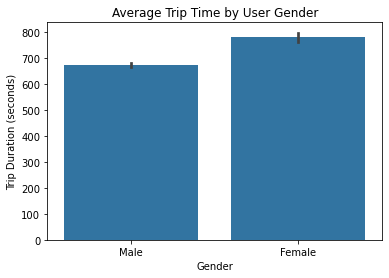

In [55]:
#considering males and females only
base_color = sb.color_palette()[0]
sb.barplot(data=df.query('member_gender in ["Male", "Female"]'), x='member_gender', y='duration_sec', color=base_color)
plt.title('Average Trip Time by User Gender')
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Gender');

## When do most trips start?

> Most trips are start during rush hours. Most users use the service for commuting.

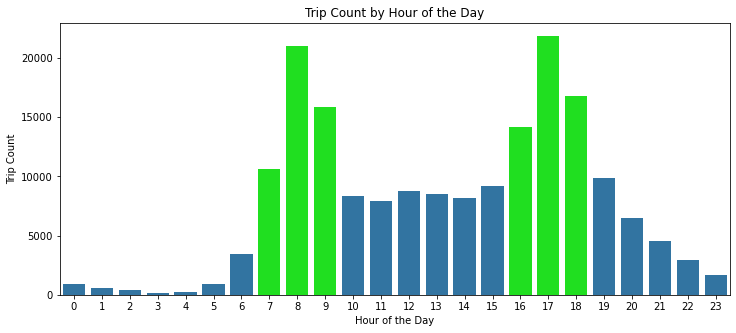

In [56]:
#First, we create a column for the hour 
df['start_hour'] = df.start_time.dt.hour
base_color = sb.color_palette()[0]
clrs = ['lime' if x in [8, 9, 10, 17, 18, 19] else base_color for x in range(1, 25)]
plt.figure(figsize=(12, 5))
sb.countplot(data=df, x='start_hour', palette=clrs)
plt.title('Trip Count by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Trip Count');

## Is commuting the trend everywhere?

> No. San Jose people doesn't seem to follow the trend.

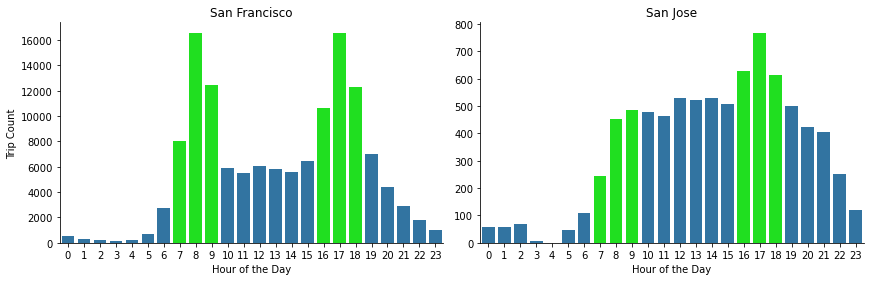

In [57]:
#Create a city column
df.loc[df.start_station_longitude < -122.3537, 'city'] = 'San Francisco'
df.loc[(df.start_station_longitude > -122.3537) & (df.start_station_longitude < -122.2037), 'city'] = 'Berkeley'
df.loc[df.start_station_latitude < 37.4673, 'city'] = 'San Jose'
# draw and polish the plot
g = sb.FacetGrid(data=df[df.city != 'Berkeley'], col='city', sharey=False, height=4, aspect=9/6)
g.map(sb.countplot, 'start_hour', order=range(0,24), palette=clrs)
g.set_xlabels('Hour of the Day')
g.set_ylabels('Trip Count')
ax = g.axes
ax[0,0].set_title('San Francisco')
ax[0,1].set_title('San Jose');

## How about the weekends?

> Since most of the trips are for commuting to and from work, bookings by both sexes tend to decrease on the weekends.

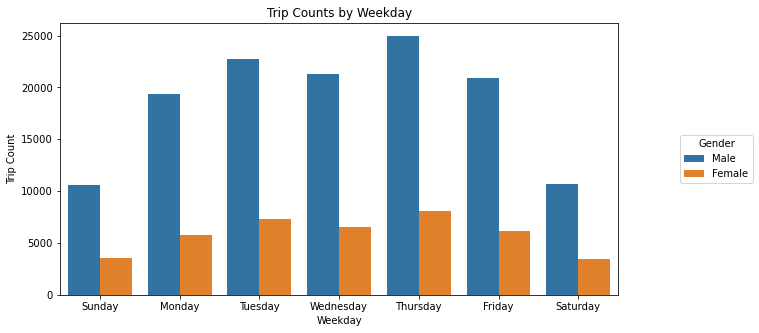

In [58]:
df['start_day'] = df.start_time.dt.day_name()
week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.figure(figsize=(10, 5))
sb.countplot(data=df.query('member_gender in ["Male", "Female"]'), x='start_day', hue='member_gender', order=week)
plt.title('Trip Counts by Weekday')
plt.ylabel('Trip Count')
plt.xlabel('Weekday')
plt.legend(title='Gender', bbox_to_anchor=(1, 0, 0.25, 1), loc="center right");

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!